In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
#from itertools import chain
import math

In [2]:
# Data params
textures = 11
trials = 100

# Set bin and sim params
bin_size = 250   # Bin size in ms
sim_length = 5000   # Sim time in ms
bins = math.ceil(sim_length / bin_size)

# Used to iterate through windows
#data_length = list(range(100,5000, 100))   # 100ms intervals by which to use for classifier
data_bin_numbers = [x / bin_size for x in range (bin_size, sim_length, bin_size)]   # Number of bins each iteration will include

In [3]:
# Import clipped dataset and labels from pickle
PATH = "/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/datasets/TacTip_NM/natural_classifier/" #300ms clipped
DATA_NAME = str(sim_length) + "ms - " + str(bin_size) + "ms bin size dataset.pickle"
LABEL_NAME = str(textures) + " textures - " + str(trials) + " trials labels.pickle"
SAVE_PATH = '/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/natural_classifier/'

# Import dataset first
FILENAME = PATH + DATA_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        dataset = pickle.load(openfile)
    except EOFError:
        print(EOFError)
        
# Now import label array
FILENAME = PATH + LABEL_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        labels = pickle.load(openfile)
    except EOFError:
        print(EOFError)

In [4]:
# Function to set appropriate figure size for publication
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


In [5]:
width = 516 # Width of document in publication

In [6]:
# WARNING: Dataset created from previous script contains a NULL row 0
#          This row has currently been deleted and saved over the initial dataset
#          Note for next time is to fix this bug
#print(dataset[0])
#dataset = np.delete(dataset, 0, 0)
#print(len(dataset))
if len(dataset) == (trials * textures)+1:
    dataset = np.delete(dataset, 0, 0)

In [7]:
# Function to slice a nested loop
# Slice list = array[start:stop:step]
def slice_nest(data, start, stop, step):
    #new_arr = np.ones_like(data)   # Create array to contain new sliced sublists
    new_list = []   # List to contain sliced sublist
    
    # Loop through data and slice each sublist - if exists
    for sublist in data:
        new_list.append(sublist[start:stop:step])
        
    # Stack data in column vector numpy array
    #new_arr = np.array(new_list)
    
    # Return sliced array of lists
    return np.array(new_list)

In [8]:
# Assess naive bayes over a range of window sizes
# Lists to contain accuracy data
train_accuracies = []
#     train_recall = []
#     train_precision = []

val_accuracies = []
#     val_recall = []
#     val_precision = []
    
# List to track fold accuracies
fold_train_acc = []
fold_val_acc = []
    
# Total confusion arrays
#    Y_true = []
#   Y_Pred = []

# Create kfold validation model
folds = 10
kf = KFold(n_splits=folds, random_state=63, shuffle=True)


# Loop through window sizes
for num in data_bin_numbers:
    
    # Take first 'num' data points as the data window for this loop
    num_dataset = slice_nest(dataset, 0, int(num), 1)
    
    # Split data into testing and training
    # Ration currently 80-20
    x_train, x_test, y_train, y_test = train_test_split(num_dataset, labels, test_size=0.2)
    

    # Convert training data to np arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Create bayes classifier
    bayes = GaussianNB()

    # Loop through each of the folds within the kfold
    for train_index, val_index in kf.split(x_train):
        # Create folded data
        Xtrain, Xval = x_train[train_index], x_train[val_index]
        ytrain, yval = y_train[train_index], y_train[val_index]

        # Fit the model to the new folded training data
        bayes.fit(Xtrain, ytrain)

        # Precit value using Bayes
        #y_pred = knn.predict(x_test)
        pred_train = bayes.predict(Xtrain)
        pred_val = bayes.predict(Xval)

        # Append values to seperate array for confusion matrix
#         Y_true.append(yval)
#         Y_Pred.append(pred_val)

        #Calculate the accuracy of the predictions on the training set 
        #and save in the variable train_accuracies
        fold_train_acc.append(accuracy_score(ytrain, pred_train))
#         train_recall.append(recall_score(ytrain, pred_train, average='micro'))
#         train_precision.append(precision_score(ytrain, pred_train, average='micro'))

        #Do the same for the predictions on the validation set
        fold_val_acc.append(accuracy_score(yval, pred_val))
#         val_recall.append(recall_score(yval, pred_val, average='micro'))
#         val_precision.append(precision_score(yval, pred_val, average='micro'))
    
    # Append the average accuracy for this window size
    train_accuracies.append(np.mean(fold_train_acc))
    val_accuracies.append(np.mean(fold_val_acc))
    
    # Empty fold tracking lists
    fold_train_acc = []
    fold_val_acc = []
    
    # Debug print statement
    print(str(num * bin_size) + "ms window complete")

250.0ms window complete
500.0ms window complete
750.0ms window complete
1000.0ms window complete
1250.0ms window complete
1500.0ms window complete
1750.0ms window complete
2000.0ms window complete
2250.0ms window complete
2500.0ms window complete
2750.0ms window complete
3000.0ms window complete
3250.0ms window complete
3500.0ms window complete
3750.0ms window complete
4000.0ms window complete
4250.0ms window complete
4500.0ms window complete
4750.0ms window complete


In [9]:
#Calculate the mean for training and validation accuracies
train_accuracy_mean = np.mean(train_accuracies)
val_accuracy_mean = np.mean(val_accuracies)

# train_recall_mean = np.mean(train_recall)
# val_recall_mean = np.mean(val_recall)

# train_precision_mean = np.mean(train_precision)
# val_precision_mean = np.mean(val_precision)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


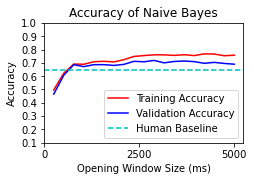

In [10]:
# Print mean values for accuracies
#print(train_accuracy_mean)
# print(val_accuracy_mean)
# print(np.max(val_accuracies))

# Plot this data
x = np.linspace(data_bin_numbers[0] * bin_size, sim_length, len(data_bin_numbers))
xtick = np.arange(0, sim_length + 10, bin_size * 10)

fig, ax = plt.subplots(figsize=set_size(width, fraction=0.5))

ax.plot(x, train_accuracies, color='r',label='Training Accuracy')
ax.plot(x, val_accuracies, color='b',label='Validation Accuracy')
plt.axhline(y = 0.65, color = 'c', linestyle = '--', label='Human Baseline')  # Line to indicate the human baseline
plt.xlabel("Opening Window Size (ms)")
plt.ylabel("Accuracy")
plt.title("Accuracy of Naive Bayes")
#plt.xticks(range(data_bin_numbers[0] * bin_size, sim_length, )))
plt.xticks(xtick)
plt.yticks(np.arange(0.1, 1.1, step=0.1))
ax.legend()
plt.savefig(SAVE_PATH + DATA_NAME + " Bayes_accuracy_baseline.eps", bbox_inches="tight")
plt.show()

In [11]:
# # Print mean values for recall
# print(train_recall_mean)
# print(val_recall_mean)

# # Plot this data
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(x, train_recall, color='r',label='Training Recall')
# ax.plot(x, val_recall, color='b',label='Validation Recall')
# plt.xlabel("Fold No.")
# plt.ylabel("Recall")
# plt.title("Recall of Naive Bais for " + DATA_NAME)
# plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/bayes_results/" +
#                     DATA_NAME + " recall.png")
# ax.legend()
# plt.show()

In [12]:
# # Print mean values for precision
# print(train_precision_mean)
# print(val_precision_mean)

# # Plot this data
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(x, train_precision, color='r',label='Training Precision')
# ax.plot(x, val_precision, color='b',label='Validation Precision')
# plt.xlabel("Fold No.")
# plt.ylabel("Precision")
# plt.title("Precision of Naive Bais for " + DATA_NAME)
# plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/bayes_results/" +
#                     DATA_NAME + " precision.png")
# ax.legend()
# plt.show()

In [13]:
# Y_true = [item for sublist in Y_true for item in sublist]
# #print(Y_true)
# Y_Pred = [item for sublist in Y_Pred for item in sublist]

In [14]:
#cnf_matrix = confusion_matrix(Y_true, Y_Pred)

In [15]:
# plt.figure(figsize=(6, 6))
# plt.xticks(range(11))
# plt.yticks(range(11))
# plt.imshow(cnf_matrix)
# plt.title('Confusion matrix')
# plt.savefig(SAVE_PATH + DATA_NAME + " BAYES confusion.png")
# plt.show()
# cnf_matrix

In [16]:
# norm = np.linalg.norm(cnf_matrix)
# normal_cnf = cnf_matrix/norm

In [17]:
# plt.figure(figsize=(6, 6))
# plt.xticks(range(11))
# plt.yticks(range(11))
# plt.imshow(normal_cnf)
# plt.title('Normalised Confusion matrix')
# plt.savefig(SAVE_PATH + DATA_NAME + " BAYES normalised confusion.png")
# plt.show()
# normal_cnf